## Exercise 1.3 

Sometimes we will encounter estimators (e.g., Maximum likelihood) that adopt an assumption of independence, rather than mean independence. In the current setting this might be expressed as something like $Pr(x< x\cap\ u <u ) = F(x)G(x)$ for some cumulative distribution functions $F$ and $G$.

Show that independence implies mean independence, but not the converse.

#### 1. Independence Implies Mean Independence

Supposing two random variables $X$ and $U$, they can be expresed as:
$Pr(X < x \cap\ U <u) =Pr(X<x)⋅Pr(U<u)$

Suposing the mean value of a function $h(X,U)$ under this independance assumption $$E[h(X,U)] = \int\int h(x,u) f_x(x) f_u(u) dx du=(\int h(x,u)f_x(x)dx)⋅(\int h(x,u)f_u(u)du)$$
The separation of integrals is possible due to independence. Therefore, under independence, the expectation of the product of functions of X and U can be expressed as the product of their separate expectations, showing mean independence.

#### 2. Mean Independence Does Not Imply Independence
Let's consider two random variables, X and U, with covariance $Cov(X,U)=0$ but not necessarily independent.In this case, we can have $E[XU]=E[X]⋅E[U]=0$ This means that X and U are mean independent, but they are not necessarily independent. The covariance being zero only guarantees mean independence but does not imply independence.




## Exercise 1.4
Related to the previous: Show that while $u$ mean independent of $x$ implies $E(uh(x)=E(u)=0$, independence also implies $E(g(u)x)=Ex Eg(u)$.



Mean independence implies $E(uh(x))=E(u)=0$. 
Given mean independence between u and x, we have $E(uh(x))=E(u)⋅E(h(x))$. Since $E(h(x))$ is a constant, this implies that if $E(u)=0$, then $E(uh(x)=0$.

Independence implies $E(g(u)x)=E(x)⋅E(g(u))$.
When $u$ and $x$ are independent, we can express the expectation of their product $g(u)⋅x$ as: 
$E(g(u)x) = \int\int g(u)⋅x⋅f_{UX}(u,x) du dx$ where $f_{UX}$ is the join probability density function of $u$ and $x$. By the definition of independence, the join probability density function can be factorized as $f_{UX}(u,x)=f_{U}(u)⋅f_{X}(x)$. Substituting this into the expectation equation gives: $E(g(u)x)=\int\int g(u)⋅x⋅f_{U}(u)⋅f_{X}(x)dudx=(\int g(u)⋅f_{U}(u)du⋅(\int x⋅f_X(x)dx) = E(g(u))⋅E(x)$

Therefore, under independence, the expectation of the product $g(u)⋅x$ is the product of their separate expectations, $E(x)$ and $E(g(u))$.


## Exercise 4. Weak Instrument
This problem explores the problem of weak instruments. The basic setup should be familiar, with

$y=\beta x+u$ <br/> $y=Z\pi x+v$ 

Note that we've assumed that x is a scalar random variable, and that Z is an $l$-vector. (In general we might have k endogenous $x$ variables, so long as we have $l>k$).


(1) Construct a data-generating process **dgp** which takes as arguments (n; β; π) and returns a triple (y, x, Z) of n observations.

In [124]:
%reset -f
import numpy as np

def data_generating_process(n, beta, pi):
    # Generate x as a random scalar variable
    x = np.random.normal(size=n)
    
    # Generate Z as an l-vector
    l = len(pi)
    Z = np.random.normal(size=(n, l))
    
    # Generate u and v as random noise
    u = np.random.normal(size=n)
    v = np.random.normal(size=n)
    
    # Generate y using the DGP equations
    y = beta * x + u
    y += np.dot(Z, pi) * x + v
    
    return y, x.reshape(-1, 1), Z

# Example usage:
n = 1000
beta = 0.5
pi = np.array([0.2, 0.3])  # Example values for pi
y, x, Z = data_generating_process(n, beta, pi)

#print(Z)
#print(y)
#print(x)

(2) Use the dgp function you've constructed to explore IV (2SLS) estimates of β as a function of π when $l= 1$ using a Monte
Carlo approach, assuming homoskedastic errors.

a) Write a function two_sls which takes as arguments (y; x; Z) and returns two-stage least squares estimates of β and the standard error of the estimate.

In [125]:
import numpy as np
import pandas as pd

def two_sls(y, x, Z):
    beta_hat1 = np.linalg.solve(Z.T @ Z, Z.T @ x)
    x_hat = Z @ beta_hat1 
    XtX = x_hat.T @ x_hat
    XtY = x_hat.T @ y
    beta_hat = np.linalg.solve(XtX, XtY)
    e = y - x_hat @ beta_hat
    S2_e = np.dot(e.T, e) / (x.shape[0] - x.shape[1])
    Vb_ols = np.linalg.inv(x_hat.T @ x_hat) * S2_e
    se = np.sqrt(np.diag(Vb_ols))
    return beta_hat.flatten(), se.flatten()

b, se = two_sls(y, x, Z)
print("Estimated Coefficients (b):\n", b)
print("Standard Errors (se):\n", se)    


Estimated Coefficients (b):
 [-0.45120484]
Standard Errors (se):
 [1.31565204]


(b) Taking β = π = 1, use repeated draws from dgp to check the bias, and precision of the two_sls estimator, as well as the size and power of a t-test of the hypothesis that β = 0.

In [127]:
from scipy.stats import t as t_dist

# Parameters for simulation
n_simulations = 1000
n_samples = 100
beta_true = 1
pi_true = np.array([1])

# Initialize lists to store results
bias = []
precision = []
t_test_results = []

# Initialize coverage count
coverage_count = 0

# Run the Monte Carlo simulation
for _ in range(n_simulations):
    y, x, Z = data_generating_process(n_samples, beta_true, pi_true)
    beta_hat, se = two_sls(y, x, Z)
    
    # Compute bias and precision
    bias.append(np.mean(beta_hat) - beta_true)
    precision.append(np.mean(se))
    
    # Perform t-test
    t_stat = beta_hat / se
    p_value = 2 * (1 - t_dist.cdf(np.abs(t_stat), df=n_samples - x.shape[1]))
    t_test_results.append(p_value < 0.05)  # Significance level of 0.05

    # Check if true beta is within the 95% confidence interval
    if (beta_true > beta_hat - 1.96 * se) and (beta_true < beta_hat + 1.96 * se):
        coverage_count += 1
        
# Calculate coverage probability
coverage_probability = coverage_count / n_simulations
    
# Aggregate results
bias_mean = np.mean(bias)
precision_mean = np.mean(precision)
size = np.mean(t_test_results)
power = 1 - size

# Print results
print("Bias:", bias_mean)
print("Precision (Standard Error):", precision_mean)
print("Size of t-test (Type I Error Rate):", size)
print("Power of t-test (1 - Type II Error Rate):", power)


Bias: 1.6443410499626703
Precision (Standard Error): 8.371473721788334
Size of t-test (Type I Error Rate): 0.101
Power of t-test (1 - Type II Error Rate): 0.899


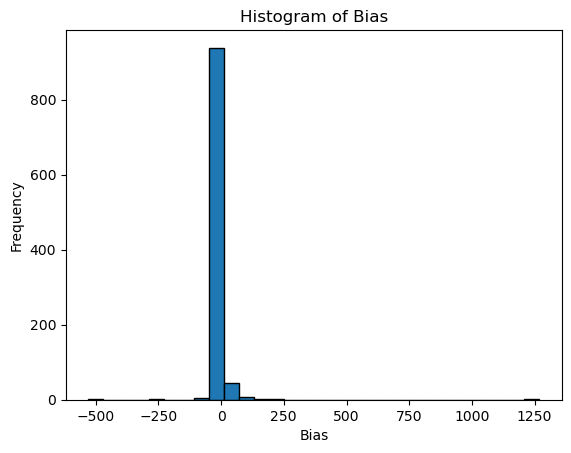

In [128]:
import matplotlib.pyplot as plt
plt.hist(bias, bins=30, edgecolor='black')
plt.xlabel('Bias')
plt.ylabel('Frequency')
plt.title('Histogram of Bias')
plt.show()

Discuss. Does a 95% confidence interval (based on your2SLS estimator) correctly cover 95% of your Monte Carlo
draws?

In [129]:
print("Coverage Probability:", coverage_probability)

Coverage Probability: 0.91


Based on my results, I would say it covers correctly.

Taking β = 1, but allowing $π \in [0,1]$ again evaluate the bias and precision of the estimator, and the size and power of a t-test. The Z instrument is "weak" when π is "close" to zero. Comment on how a weak instrument affects two-stage least squares estimators.

In [130]:
# Parameters for simulation
# Parameters for simulation

n_simulations = 1000
n_samples = 100
beta_true = 1
pi_range = np.linspace(0, 1, 11)  # Vary pi from 0 to 1

# Initialize arrays to store results
bias = np.zeros(len(pi_range))
precision = np.zeros(len(pi_range))
size = np.zeros(len(pi_range))
power = np.zeros(len(pi_range))

# Run the Monte Carlo simulation for each pi value
for idx, pi_value in enumerate(pi_range):
    # Initialize counters
    bias_sum = 0
    se_sum = 0
    size_count = 0
    power_count = 0
    
    for _ in range(n_simulations):
        y, x, Z = data_generating_process(n_samples, beta_true, np.array([pi_value]))
        beta_hat, se = two_sls(y, x, Z)
        
        # Compute bias and precision, with sum??? Ask ethan
        bias_sum += beta_hat - beta_true
        se_sum += se
        
        # Compute t-statistic and p-value for testing beta_hat = 0
        t_stat = beta_hat / se
        p_value = 2 * (1 - t_dist.cdf(np.abs(t_stat), df=n_samples - x.shape[1]))
        
        # Check if true beta is within the confidence interval
        if (beta_true > beta_hat - 1.96 * se) and (beta_true < beta_hat + 1.96 * se):
            size_count += 1
        if p_value < 0.05:
            power_count += 1
    
    # Calculate average bias, precision, size, and power
    bias[idx] = bias_sum / n_simulations
    precision[idx] = se_sum / n_simulations
    size[idx] = size_count / n_simulations
    power[idx] = power_count / n_simulations



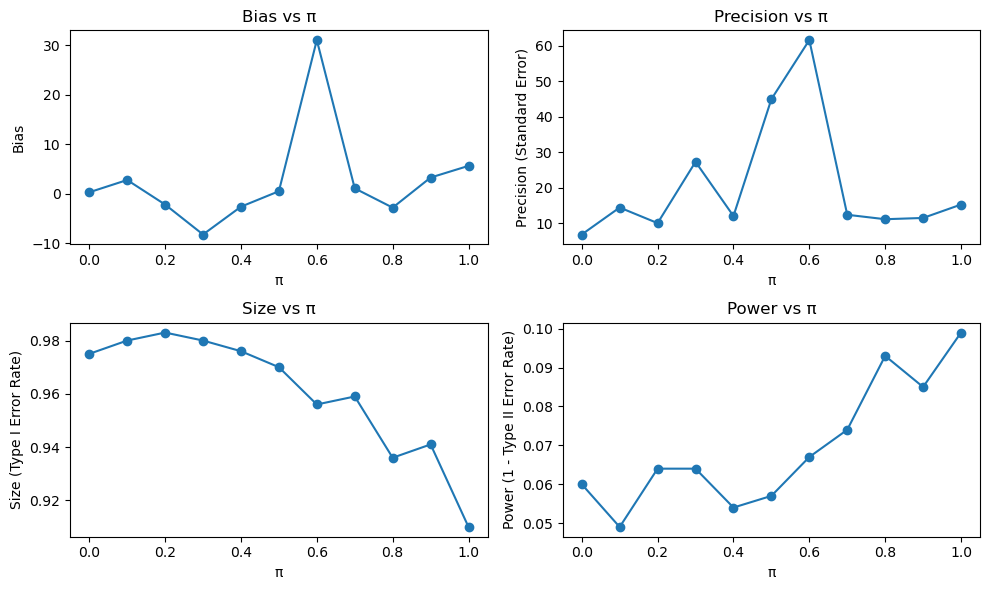

In [131]:
# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(pi_range, bias, marker='o')
plt.xlabel('π')
plt.ylabel('Bias')
plt.title('Bias vs π')

plt.subplot(2, 2, 2)
plt.plot(pi_range, precision, marker='o')
plt.xlabel('π')
plt.ylabel('Precision (Standard Error)')
plt.title('Precision vs π')

plt.subplot(2, 2, 3)
plt.plot(pi_range, size, marker='o')
plt.xlabel('π')
plt.ylabel('Size (Type I Error Rate)')
plt.title('Size vs π')

plt.subplot(2, 2, 4)
plt.plot(pi_range, power, marker='o')
plt.xlabel('π')
plt.ylabel('Power (1 - Type II Error Rate)')
plt.title('Power vs π')

plt.tight_layout()
plt.show()


(3) Now consider another "weak" instruments problem. Consider the sequence {1,1/2,1/4,1/8,...}. Let $l$=1,2,3,..., and for a particular value of $l$ let the vector of parameters $π_l$ consist of the first $l$ elements of the sequence. Thus, your dgp should now return Z we can treat as an n × l matrix, with successive columns of Z increasingly "weak" instruments.

(a) Taking β = 1, but allow l to increase (l = 1,2,...). Note that for l>1 this is now an "overidentifed" estimator.
Describe the bias and precision of the estimator, and the size and power of a t-test. Compare with the case of l=1
and π = 1.

(b) What can you say about the optimal number of instruments (choice of l) in this case?

In [146]:
### not suree :(